# Prédiction de la performance du SP500 à partir d'indices de "sentiment du marché"

**Projet Python - 2A ENSAE** . 

Elena Loumagne / Jérémie Darracq 

## Introduction 

Objectifs : Il s'agit de prédire les performances du SP500 à partir d'indices de "sentiment du marché". Il existe de nombreux indicateurs de "sentiment du marché" mais dans ce projet nous choisirons un indicateur directe à savoir l'indice de volatilité du SP500 où plutôt indice VIX et un indicateur indirecte que nous allons construire à partir d'une base de donnée d'articles traitant du SP500. 

Projet : il se découpe en trois parties 

- 1ère partie (voir notebook_récup_data_webscrapping /notebook_récup_data_API_finhub) : l'extraction des données sur la performance du SP500 (indice de performance SP500) et sa volatilité (indice VIX)/ la récupération des articles traitant des companies du SP500 via une API.   

- 2ème partie (notebook_récup_data_API_finhub) : Le traitement des données incluant le nettoyage du résumé des articles. 

- 3ème partie (notebook_analyse_data) : L'analyse des données par des statistiques descriptives /l'analyse de sentiment puis une construction de notre indice indirecte pour la réalisation d'un modèle de prédiction. 




## Sources

- Pour l'API finhub : https://python.plainenglish.io/access-historical-financial-news-headlines-with-python-be1b8faaea9f      
- Pour l'API twitter : https://towardsdatascience.com/sentiment-analysis-for-stock-price-prediction-in-python-bed40c65d178    
- Pour la prédiction : https://sentometrics-research.com/sentometrics/articles/applications/vix.html​




## Definitions 
- "sentiment du marché" : renvoie à l’humeur générale des investisseurs sur un marché particulier. Le sentiment du marché a bien sûr un impact sur le cours du marché concerné. Lorsque le cours est en hausse, on dit souvent du sentiment du marché qu’il est haussier. Mais, lorsque le cours du marché est en baisse, on dit que le sentiment du marché est baissier. L’expression « sentiment du marché » renvoie à l’émotion qui domine parmi les investisseurs d’un marché donné : par exemple, la peur ou l’optimisme. 


- SP500 : indice boursier basé sur 500 grandes sociétés cotées sur les bourses aux États-Unis (NYSE ou NASDAQ). Il couvre environ 80 % du marché boursier américain par sa capitalisation.  



-  indice VIX : indicateur de volatilité du marché financier établit par le Chicago Board option Exchange.Le cours des options est considéré comme une bonne mesure de la volatilité car si quelque chose suscite de l’inquiétude sur le marché, les traders et les investisseurs ont tendance à se positionner à l’achat sur les options, ce qui entraîne une hausse des cours. C’est la raison pour laquelle le VIX est également appelé « indice de la peur », puisqu’il mesure le niveau de peur et de stress sur le marché.


- FINHUB : API fournissant des articles financiers concernant les plus grandes entreprises mondiales. 

## Import des packages 

In [529]:
## Package pour la statistique descriptive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import imshow
import seaborn as sns
import scipy
from scipy.stats import chi2_contingency as chi2_contingency
import datetime

## Packages pour l'analyse de sentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud,STOPWORDS


## Package pour le modèle de prédiction
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf


## I - Exploration des données et statistique descriptive

Dans cette partie, nous allons étudier la base de donnée d'articles que nous avons récupéré.

In [503]:
## On importe les articles propres 
article_data = pd.read_csv("Data/data_finhub.csv")

### Statistiques descriptives

In [504]:
article_data.groupby("source")["abstract"].count().reset_index().sort_values(by="abstract",ascending=False).transpose()

,26,18,13,4,17,10,23,1,24,11,...,12,14,5,16,9,15,25,22,0,8
source,Yahoo,SeekingAlpha,MarketWatch,CNBC,Reuters,GuruFocus,Thefly.com,Alliance News,TipRanks,InvestorPlace,...,Market News Video,PR Newswire,Dividend Channel,Preferred Stock Channel,GlobeNewswire,PennyStocks,United Press International,The Online Investor,Accesswire,Fintel
abstract,5883,1796,1233,553,373,330,214,94,75,58,...,7,6,6,5,4,3,2,1,1,0


In [505]:
article_data.groupby("company")["abstract"].count().reset_index().sort_values(by="abstract",ascending=False).transpose()

,37,15,30,24,1,25,44,4,35,17,...,19,47,40,43,41,34,18,14,13,3
company,NVDA,COST,META,INTC,AAPL,JNJ,TSLA,AMZN,NFLX,DIS,...,FDX,WFC,PM,TMUS,SLB,NDAQ,EA,COF,CBOE,AIG
abstract,245,243,239,239,238,237,237,237,236,236,...,220,220,210,210,204,121,121,114,98,93


Des tableaux ci-dessus on constate que : 
- Nos articles proviennent majoritairement des site Yahoo, SeekingAlpha et MarketWatch
- Les entreprises les plus citées sont Google et Méta mais les nombres de citations pour chaque entreprise est assez similaire

Notre base de donnée présente donc des sources diverses et traite de manière homogène chaque entreprise du SP500

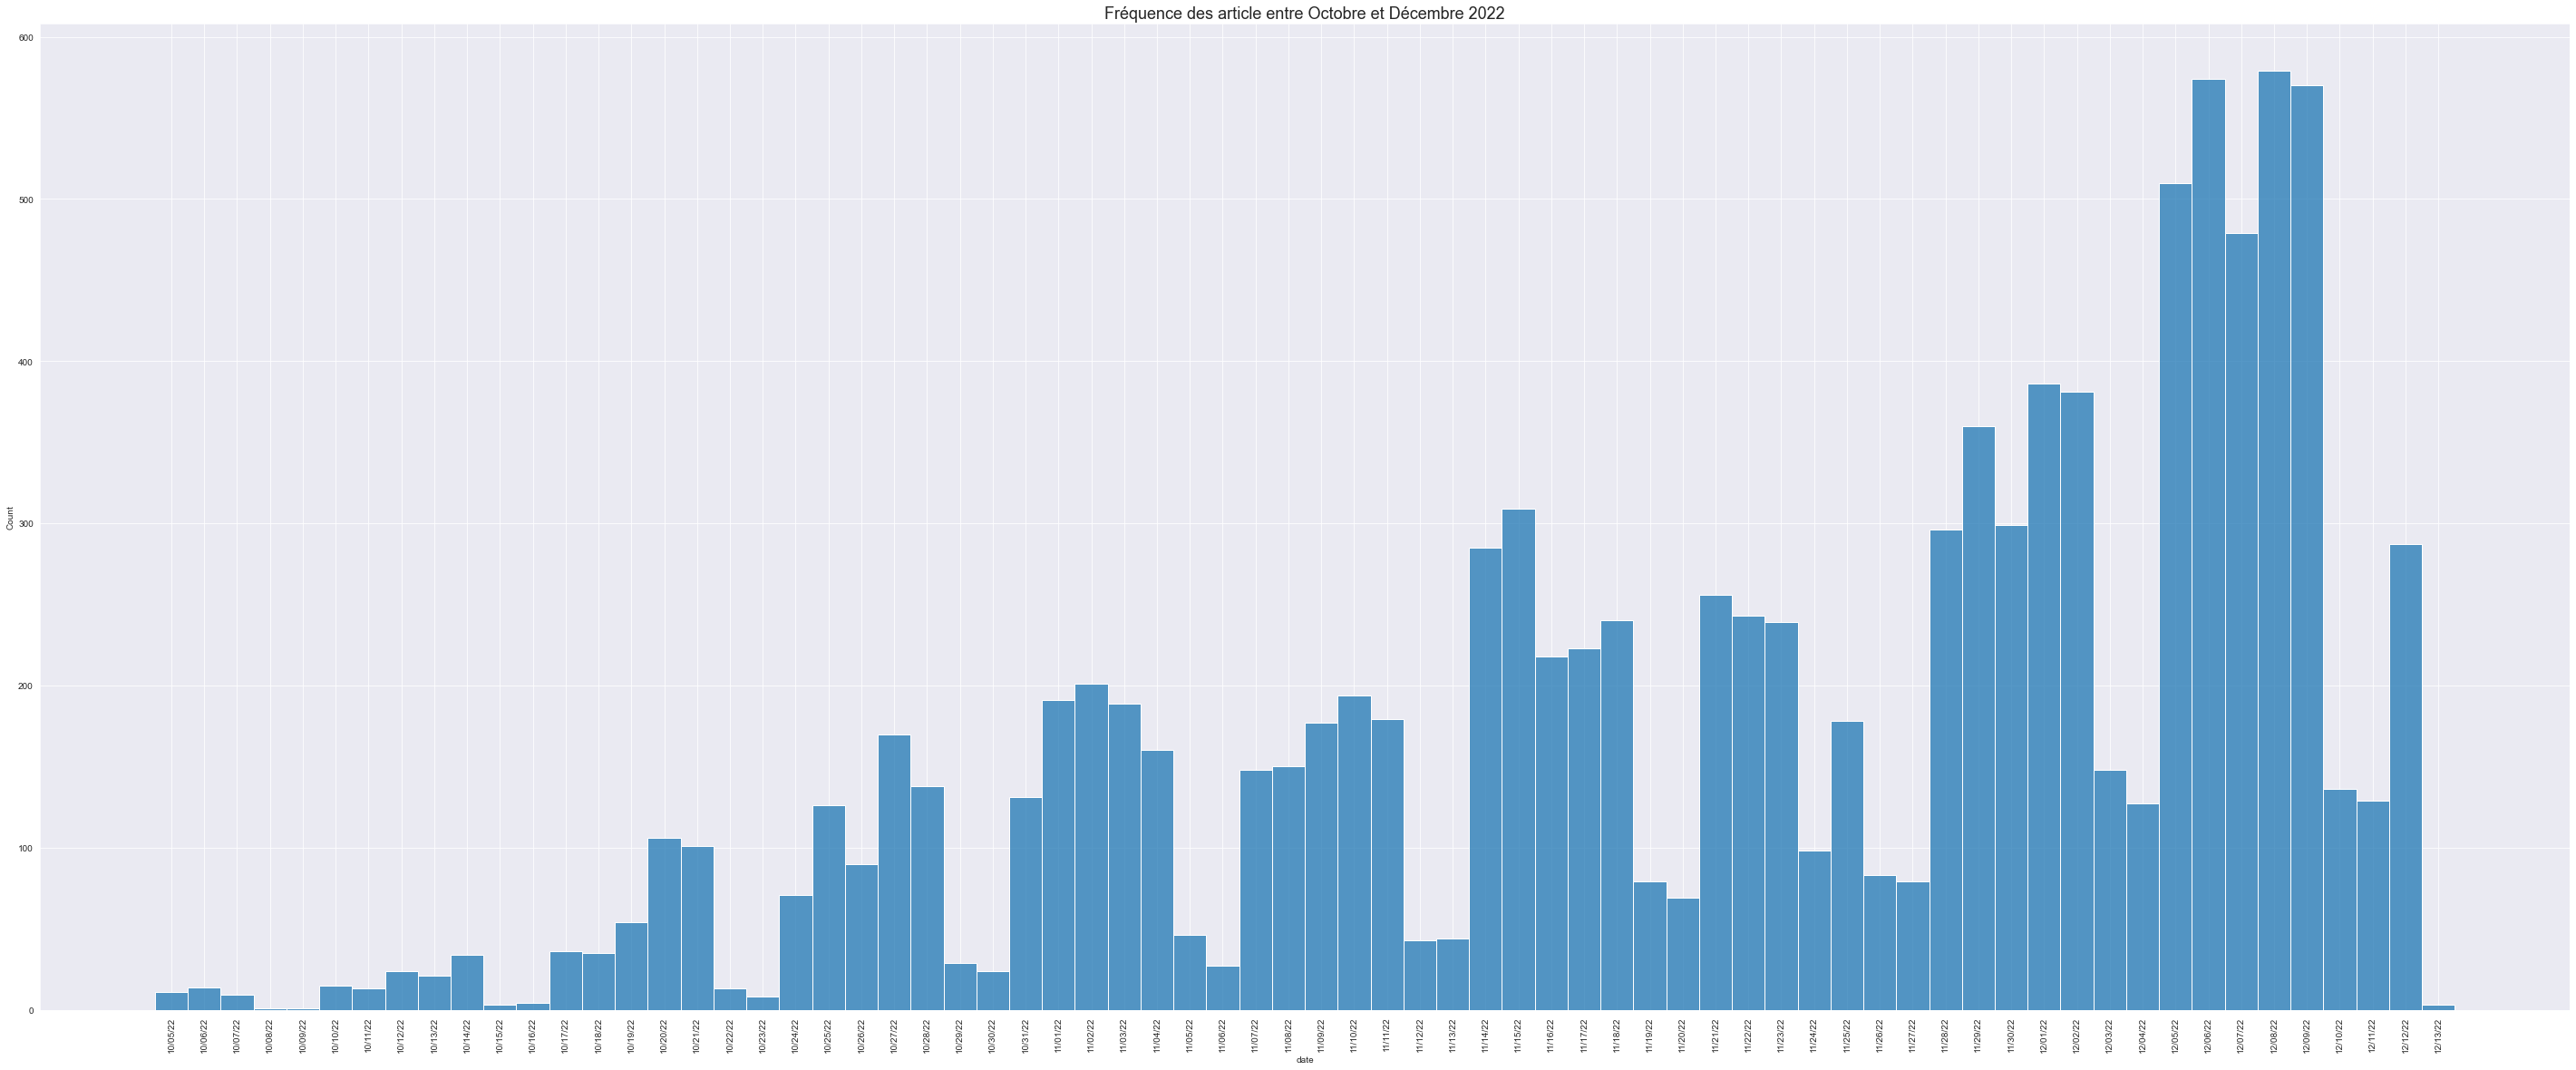

In [506]:
# Evolution de la fréquence des articles entre mars et Décembre 2022
cpalette = sns.diverging_palette(150, 30, n=3)
plt.figure(figsize=(50, 20))
sns.set_style('darkgrid')
sns.histplot(article_data, x="date")
plt.title("Fréquence des article entre Octobre et Décembre 2022", size=18)
plt.xticks(rotation = '90')
plt.show()


Du graphique ci-dessous on constate que : 
- Il y a peu de production d'article en début de période (de début à fin octobre) mais cela augmente au fur et à mesure jusqu'à atteindre un pic début décembre. Le nombre d'article s'établit entre 200 et 400 articles par jour. 

## II- Analyse de sentiment 

L'analyse de sentiment va nous permettre de faire ressortir un "sentiment du marché" au sein de notre base d'articles. 


### Calcul du sentiment des articles à partir de la polarité
Ceci est fait grâce au package **SentimentIntensityAnalyzer** qui renvoie la polarité positive pour un sentiment positif, nulle pour un sentiment neutre et négative pour un sentiment négatif.

In [507]:
sia = SentimentIntensityAnalyzer() # analiseur des sentiments

# ajout de mots spécifiques à la finance au lexique : moyenne du score de sentiment entre -4 (très négatif) et 4 (très positif)

positive_words='buy bull long support undervalued underpriced cheap upward rising trend moon rocket hold breakout call beat support buying holding high profit'
negative_words='sell bear bubble bearish short overvalued overbought overpriced expensive downward falling sold sell low put miss resistance squeeze cover seller '

dictOfpos = { i : 4 for i in positive_words.split(" ") }
dictOfneg = { i : -4 for i in negative_words.split(" ")  }
Financial_words = {**dictOfpos, **dictOfneg} # déballage du dictionnaire

sia.lexicon.update(Financial_words)

In [508]:
## On calcul le sentiment des résumés de chaque article
article_data["sentiment_score_abstract"]=article_data["abstract_stemmed"].apply(lambda x: sia.polarity_scores(str(x))['compound'])

Nous codifions donc par -1 tout sentiment négatif, par 0 tout sentiment neutre et par 1 tout sentiment positif. Les fonctions suivantes sont écrites à cet effet :

In [509]:
def article_label(score):
    if score > 0.00 :
        return "positif"
    if score < 0.00 :
        return "negatif"
    else :
        return "neutre"

def article_label_score(score):
    if score > 0.00 :
        return 1
    if score < 0.00 :
        return -1
    else :
        return 0

article_data["label_abstract"]=article_data["sentiment_score_abstract"].apply(article_label)
article_data["label_score_abstract"]=article_data["sentiment_score_abstract"].apply(article_label_score)
article_data


,abstract,company,date,headline,source,abstract_clean,abstract_stemmed,sentiment_score_abstract,label_abstract,label_score_abstract
0,"NEW YORK, October 05, 2022--American Internati...",AIG,10/05/22,AIG to Report Third Quarter 2022 Financial Res...,Yahoo,"new york, october , --american international g...","new york, octob , --american intern group, inc...",0.0000,neutre,0
1,Shares of American International Group Inc. sl...,AIG,10/05/22,American International Group Inc. stock falls ...,MarketWatch,shares american international group inc slumpe...,share american intern group inc slump $ wednes...,-0.3612,negatif,-1
2,Bearish flow noted in Ele... EA,EA,10/05/22,Electronic Arts put volume heavy and direction...,Thefly.com,bearish flow noted ele ea,bearish flow note ele ea,-0.7184,negatif,-1
3,"Sony, Microsoft, Nintendo and Electronic Arts ...",EA,10/05/22,"The Zacks Analyst Blog Highlights Sony, Micros...",Yahoo,"sony, microsoft, nintendo electronic arts part...","sony, microsoft, nintendo electron art part za...",0.2023,positif,1
4,The Fly is a leading digital publisher of real...,CBOE,10/05/22,Home - The Fly,Thefly.com,fly leading digital publisher real-time financ...,fli lead digit publish real-tim financi news f...,0.0000,neutre,0
...,...,...,...,...,...,...,...,...,...,...
10889,"Cboe Global Markets, Inc. (Cboe: CBOE), a lead...",CBOE,12/12/22,Cboe Global Markets Announces Date of Fourth-Q...,Yahoo,"cboe global markets, inc (cboe: cboe), leading...","cboe global markets, inc (cboe: cboe), lead pr...",0.8481,positif,1
10890,Few retail stocks are as popular as Costco Who...,COST,12/12/22,Costco Is Down 20% From Its High. Time to Buy?,Yahoo,retail stocks popular costco wholesale (nasdaq...,retail stock popular costco wholesal (nasdaq: ...,0.9169,positif,1
10891,Oracle Corp on Monday posted better-than-expec...,MSFT,12/13/22,Oracle posts upbeat quarterly revenue on cloud...,Reuters,oracle corp monday posted better-than-expected...,oracl corp monday post better-than-expect reve...,0.7003,positif,1
10892,The facility would allow Raven SR to convert o...,CVX,12/13/22,Clean energy startup Raven SR could launch fir...,Yahoo,facility would allow raven sr convert organic ...,facil would allow raven sr convert organ wast ...,0.2263,positif,1


#### Statistiques descriptives du sentiment des articles 

<AxesSubplot:xlabel='label_abstract', ylabel='Count'>

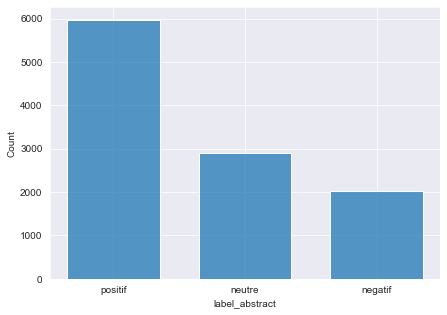

In [510]:
plt.figure(figsize=(7, 5))
sns.set_style('darkgrid')
sns.histplot(article_data.sort_values("label_abstract", ascending=False), x="label_abstract",  shrink=0.7)

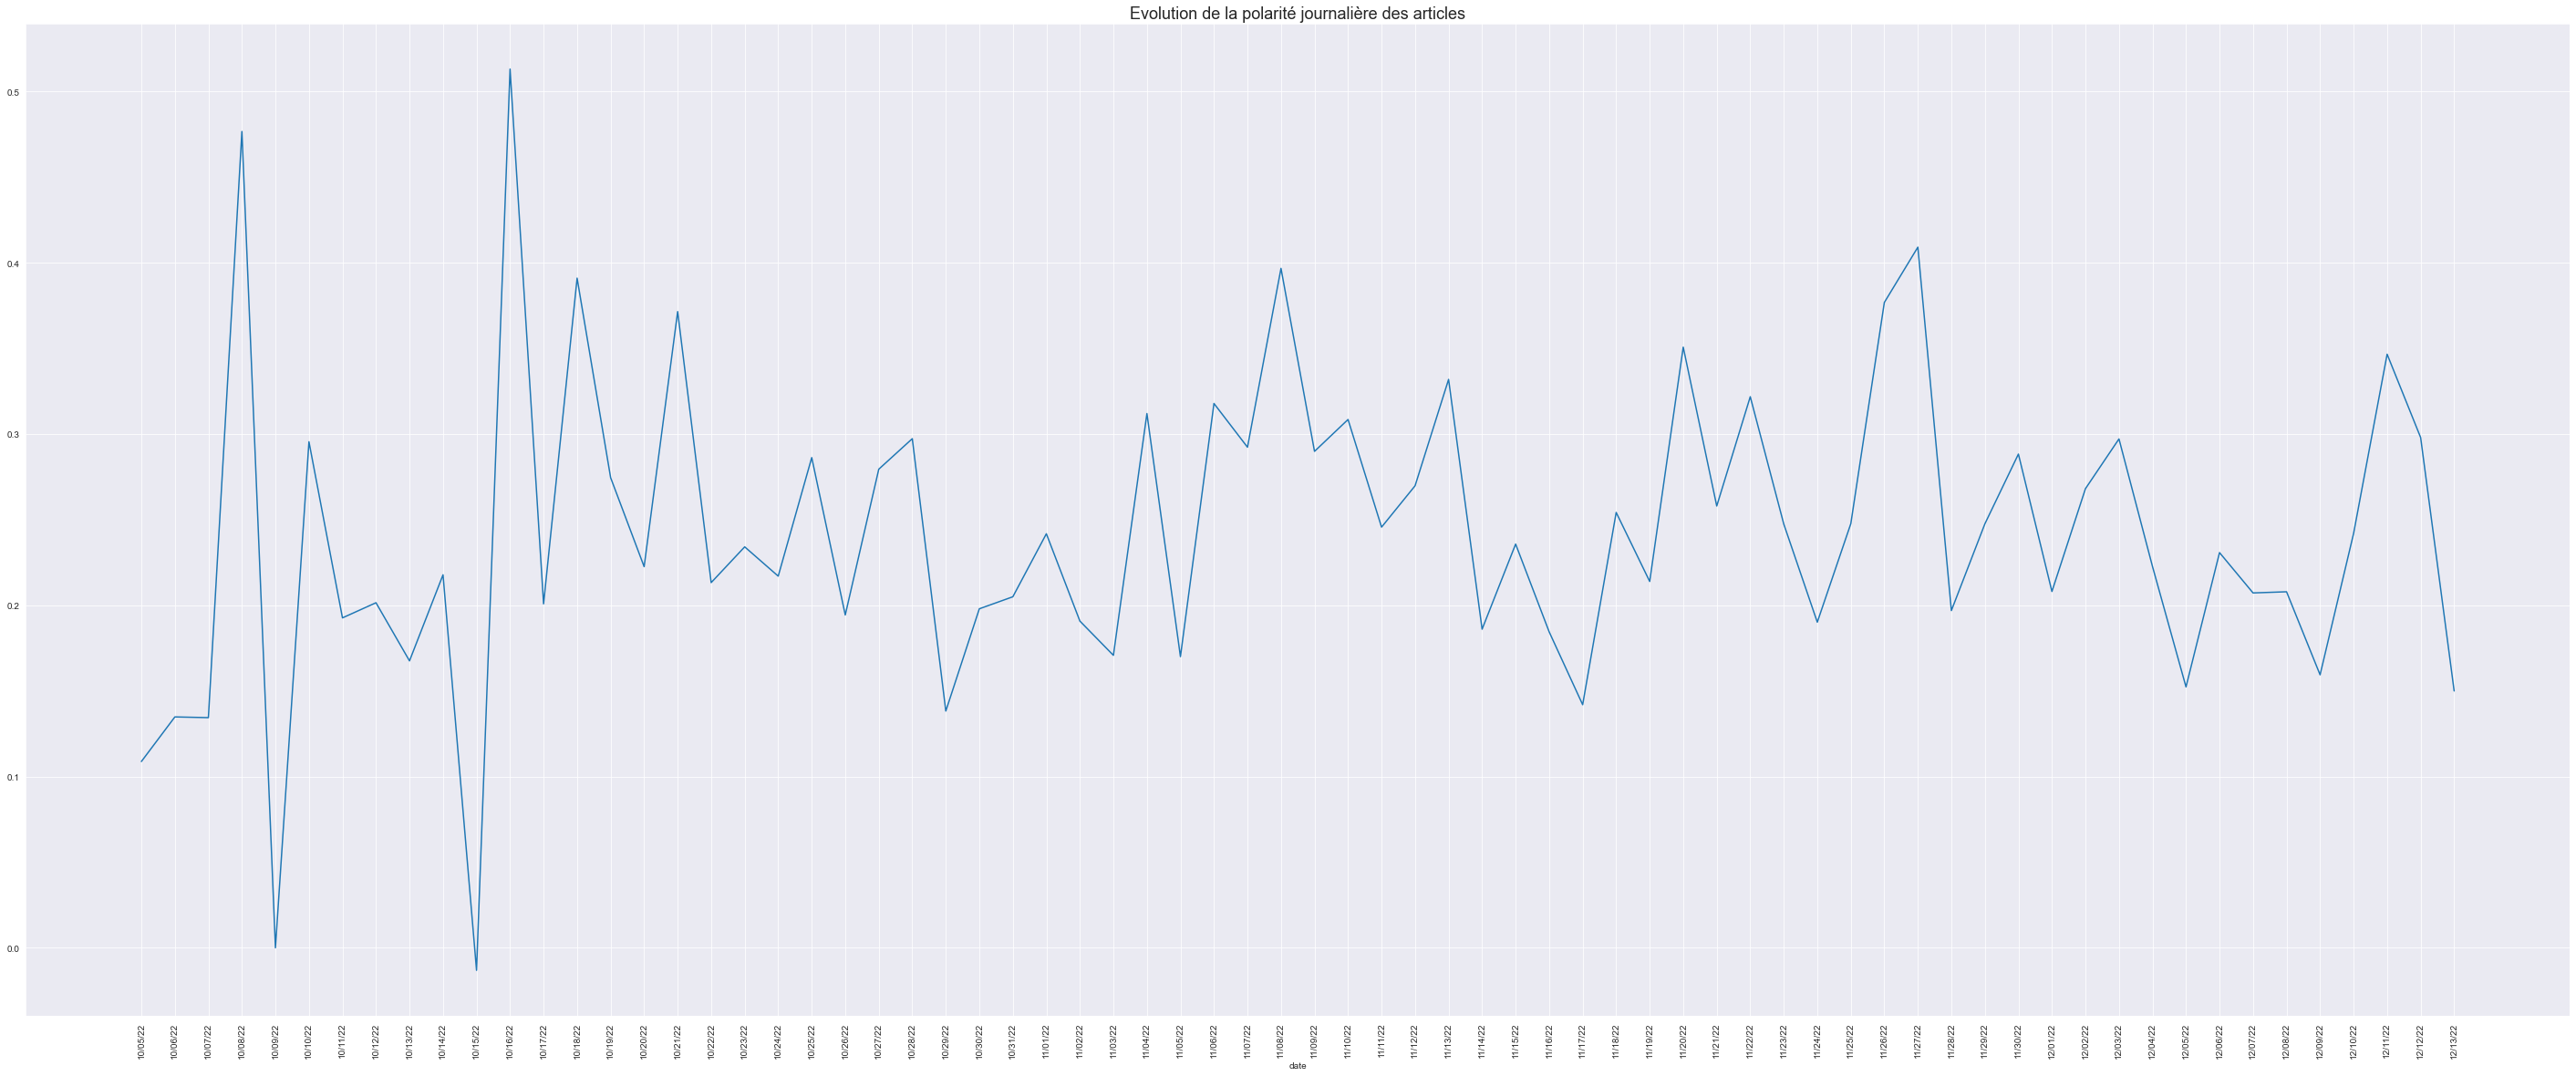

In [511]:
# Evolution de la polarité journalière des articles entre du 01 octobre 2022 au 5 décembre 2022
plt.figure(figsize=(50, 20))
plt.xlabel('date')
df2 = article_data[['date','sentiment_score_abstract']].groupby('date').mean()
plt.plot(df2)
plt.title("Evolution de la polarité journalière des articles", size=18)
plt.xticks(rotation='90')
plt.show()

Des graphiques ci-dessus on constate que : 
- Il y a environ 3 fois plus d'articles positifs que négatifs et 2 fois plus d'articles positifs que neutres. 
- En moyenne, la polarité des articles est au dessus de 0 sur la période. Celle-ci reste globalement entre 0.1 et 0.4 sur la période. 

### Relation entre le type de sentiment et les entreprises

<Figure size 7200x7200 with 0 Axes>

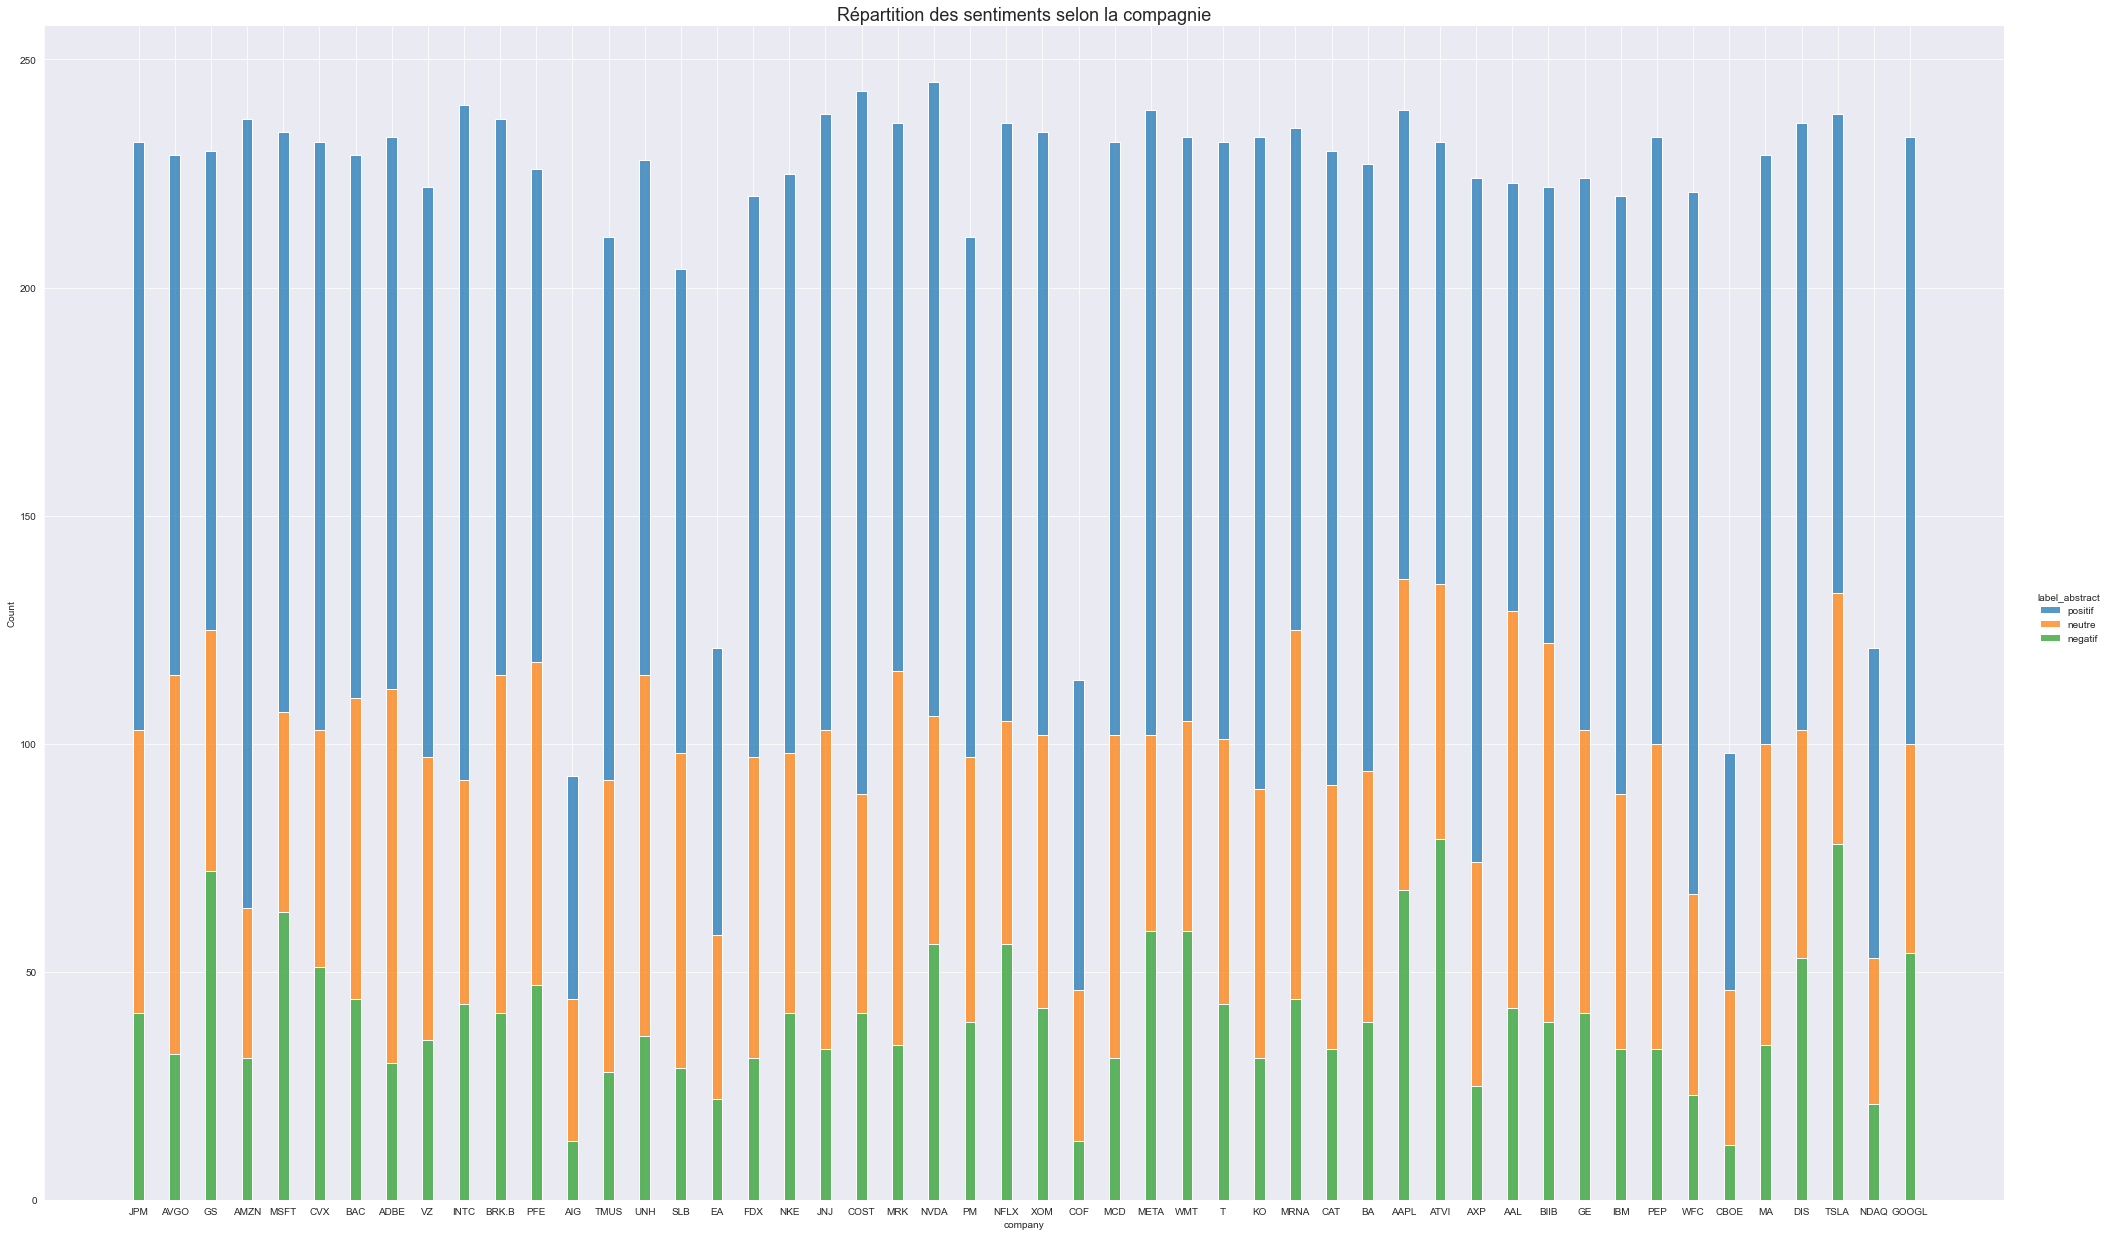

In [512]:
plt.figure(figsize=(100, 100))
cpalette = sns.diverging_palette(140, 10, n=3)
sns.displot(article_data.sort_values("label_abstract", ascending=False), x="company", hue="label_abstract", multiple="stack", shrink=0.3,height=17, aspect=20/12)

plt.title("Répartition des sentiments selon la compagnie",size=18)
plt.show()

Du graphique ci-dessus on constate que : 
- les articles positifs représentent la plus grande part des articles citant les companies du SP500 suivis des articles neutres puis négatifs illustrant un possible "sentiment du marché" haussier sur la période choisie.
- la répartition des articles positifs, neutres et négatifs semblent relativement similaire ce qui suggère une indépendance entre le type de sentiment et la companie choisie. Cela illustrerait donc une sorte de tendance de marché / sentiment global du marché. 

Nous allons donc étudier la relation entre la variable "label_abstract" qui nous renseigne sur le type de sentiment et la variable "company" qui nous renseigne sur le type de company du SP500 à l'aide d'un test d'indépendance du Khi-deux et d'un test de Cramer.

### Test du Chi-deux et Test de Cramer 

- Test du Chi-deux : Il s'agit d'un test qui compare la distribution des modalités de deux variables qualitatives. L'hypothèse du test est l'indépendance entre les deux variables. L'hypothèse est rejetée si la statistique calculée est supérieure à la valeur critique correspondante. On peut également utiliser la p-valeur qui est comparée à un seuil de significativité. Dans ce cas, l'hypothèse nulle est rejetée si cette p-valeur est inférieure au seuil. il permet donc de savoir si les variables entretiennent une relation, avec un degré de certitude plus ou moins grand. Par contre, il ne renseigne pas sur l’intensité de cette relation et la p-valeur est très sensible à la taille de l'échantillon.

- Test de Cramer : Plus le V de Cramer s’approche de 1, plus l’intensité de la relation est forte.


In [513]:
## Réalisation du test du Chi-deux 
cont=pd.crosstab(article_data["label_abstract"],article_data["company"])
khi2, pval , ddl , contingent_theorique = chi2_contingency(cont)
print('statistic: ',khi2, '\nP-value: ',pval ,'\nddl: ', ddl)

statistic:  400.62356048657335 
P-value:  3.2493188230606023e-38 
ddl:  98


In [514]:
## Fonction qui calcul le V de cramer 
def cramers(crosstab):
    chi2 = chi2_contingency(crosstab)[0]
    n = sum(crosstab.sum())
    return np.sqrt(chi2/(n*(min(crosstab.shape)-1)))

cramers(cont)

0.13559995951983692

Des résultats ci-dessus nous constatons que : 
- Au seuil de 5%, on rejette l'hypothèse nulle d'indépendance entre le type de sentiment et le type de companie du SP500 donc il existe toutefois une relation significative entre nos 2 variables quantitatives (test du Chi-deux )
- L'intensité de la relation reste cependant très faible voir nul, le V de cramer étant relativement proche de 0. 

Donc il semble possible que le type de sentiment des articles ne soit pas totalement liée à l'entreprise du SP500 qu'il considère mais possiblement à une tendance générale qu'on peut identifier comme le "sentiment du marché".

### Étude approfondies des sentiments des articles sur le SP500
On veut ici de visualiser les wordclouds selon le sentiment.

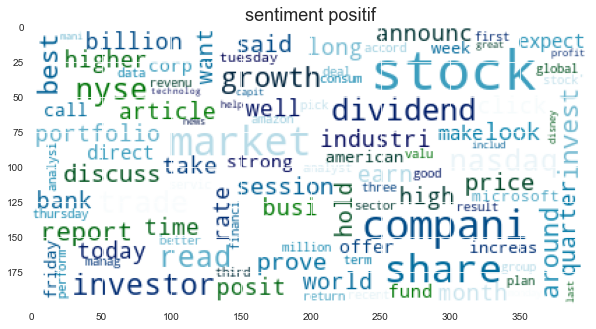

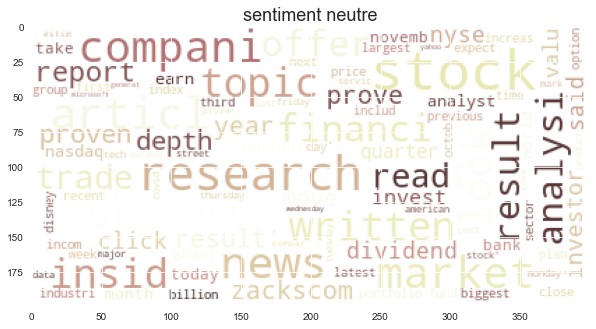

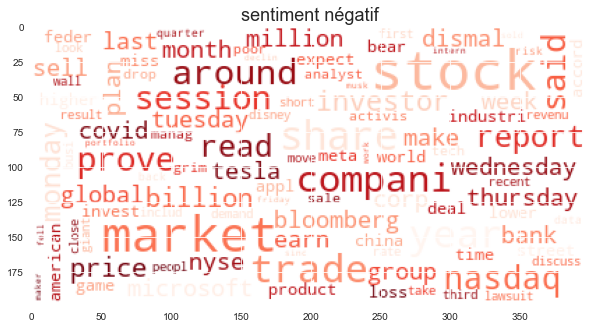

In [515]:
positive_article = []
negative_article = []
neutral_article = []

for i in range(0, article_data.shape[0]):
    if article_data['label_score_abstract'][i] == 0:
        neutral_article.append(article_data['abstract_stemmed'][i])
    elif article_data['label_score_abstract'][i] == 1:
        positive_article.append(article_data['abstract_stemmed'][i])
    elif article_data['label_score_abstract'][i] == -1:
        negative_article.append(article_data['abstract_stemmed'][i])

stopwords = set(STOPWORDS)

def show_wordcloud(data, sentiment,color):
    wordcloud = WordCloud(
        background_color='white',
        colormap=color,
        stopwords=stopwords,
        collocations=False, 
        collocation_threshold=100,
        max_words=100,
        max_font_size=40, 
        min_word_length=4,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    figure(1, figsize=(10, 10))
    imshow(wordcloud)
    plt.title("sentiment " + sentiment,size=18)
    plt.show()

show_wordcloud(positive_article,"positif","ocean_r")
show_wordcloud(neutral_article,"neutre",'pink_r')
show_wordcloud(negative_article,"négatif","Reds")

En suppossant, possible cette "tendance générale" / "sentiment de marché" nous allons voir si celle-ci peut nous permettre de prédire les performances du SP500 à partir de la construction d'un indice indirecte de "sentiment du marché"

## III Construction de l'indice indirecte de "sentiment du marché"

Après l'identification du "sentiment du marché" nous allons maintenant construire un indice représentant le "sentiment" journalier du marché. Nous proposons une méthode spécifique de calcul de cette indice.

D'abord nous découpons nos companies selon 2 groupes : 
- 1er groupe : les 14 companies ayant la plus grosse valorisation boursière du SP500 
- 2ème groupe : le reste des companies 

In [516]:
## Création d'une variable catégorielle pour classifier nos companies en 2 groupes 
List_tiers1 = ["AMZN","AAPL","META","GOOGL","BRK.B","TSLA","NVDA","JPM","JNJ","XOM","BAC","MSFT","WFC","T"]
List_tiers2 = ["PFE","NFLX","MA","MCD","GS",'INTC','TMUS',"WMT",'CBOE',"MRK","BA","MRNA","NDAQ","NKE","SLB","VZ","AXP","KAT","CVX","KO","EA","FDX","GE","IBM","UNH","PEP","COST","DIS","PM","ATVI","ADBE","AAL","AIG","BIIB","AVGO","COF"]

def categ(company):
    if company in List_tiers1:
        return "1"
    else:
        return "2"

article_data["categorie"]=article_data["company"].apply(categ)


Ensuite nous calculons un indicateur qui représente le nombre d'article positif nette moyen ( article positif - article négatif divisé par nombre total d'articles ) pour chaque groupe et cela chaque jour. On atttribue à cette l'indicateur de chaque groupe un poids qui dépend du poids de chaque groupe dans le SP500 ( ici nous avons choisi 0.9 pour le groupe 1 et 0.1 pour le groupe 2). On somme ensuite ces 2 indicateurs.

In [517]:
df_indice= (article_data.groupby(["date","categorie"])["label_score_abstract"].sum()/article_data.groupby(["date","categorie"])["label_score_abstract"].count()).reset_index()

def formula_indice(categorie,label_score):
    if categorie=="1":
        return(label_score*0.9)
    else:
        return(label_score*0.1)
    

df_indice["label_score_abstract_pondere"]=df_indice.apply(lambda x: formula_indice(x.categorie,x.label_score_abstract),axis=1)
df_indice
   

,date,categorie,label_score_abstract,label_score_abstract_pondere
0,10/05/22,2,0.181818,0.018182
1,10/06/22,2,0.357143,0.035714
2,10/07/22,2,0.222222,0.022222
3,10/08/22,2,1.000000,0.100000
4,10/09/22,2,0.000000,0.000000
...,...,...,...,...
120,12/11/22,2,0.603175,0.060317
121,12/12/22,1,0.448052,0.403247
122,12/12/22,2,0.488722,0.048872
123,12/13/22,1,1.000000,0.900000


In [518]:
df_indice = df_indice.groupby("date")["label_score_abstract_pondere"].sum().reset_index()
df_indice

,date,label_score_abstract_pondere
0,10/05/22,0.018182
1,10/06/22,0.035714
2,10/07/22,0.022222
3,10/08/22,0.100000
4,10/09/22,0.000000
...,...,...
65,12/09/22,0.212843
66,12/10/22,0.336503
67,12/11/22,0.633045
68,12/12/22,0.452119


Enfin après standardisation, on crée notre indice en sommant le score de polarité sentimentale moyen sur la journéé des articles et les indicateurs des 2 groupes. 

In [519]:
score_polarite_sentiment_moyen = article_data.groupby('date')["sentiment_score_abstract"].mean().reset_index()
score_polarite_sentiment_moyen
df_indice=df_indice.merge(score_polarite_sentiment_moyen,how="left")
df_indice

,date,label_score_abstract_pondere,sentiment_score_abstract
0,10/05/22,0.018182,0.108764
1,10/06/22,0.035714,0.134821
2,10/07/22,0.022222,0.134400
3,10/08/22,0.100000,0.476700
4,10/09/22,0.000000,0.000000
...,...,...,...
65,12/09/22,0.212843,0.159403
66,12/10/22,0.336503,0.241975
67,12/11/22,0.633045,0.346632
68,12/12/22,0.452119,0.297980


In [520]:
df_indice['label_score_abstract_pondere'] = preprocessing.scale(df_indice['label_score_abstract_pondere'])
df_indice['sentiment_score_abstract'] = preprocessing.scale(df_indice['sentiment_score_abstract'])

df_indice["indice"] = df_indice['label_score_abstract_pondere'] + df_indice['sentiment_score_abstract']
df_indice

,date,label_score_abstract_pondere,sentiment_score_abstract,indice
0,10/05/22,-1.374180,-1.488364,-2.862544
1,10/06/22,-1.306858,-1.200135,-2.506993
2,10/07/22,-1.358666,-1.204796,-2.563462
3,10/08/22,-1.060009,2.581428,1.521420
4,10/09/22,-1.443996,-2.691412,-4.135409
...,...,...,...,...
65,12/09/22,-0.626704,-0.928235,-1.554939
66,12/10/22,-0.151867,-0.014895,-0.166763
67,12/11/22,0.986817,1.142727,2.129544
68,12/12/22,0.292085,0.604581,0.896666


## III - Modèle de prédiction

Dans cette partie, nous allons d'abord étudier l'utilité de notre indice de "sentiment de marché" dans la prédiction des performances du SP500 puis proposer avec l'indice VIX du SP500 un modèle de prédiction augmenté.

In [521]:
## On importe les indices de volatilité et de performance du SP500 webscrappés 
df_sp500 = pd.read_csv('Data/data_sp500.csv')
df_vix = pd.read_csv('Data/data_vix.csv')

### Régression linéaire I : l'utilité de notre indice "sentiment de marché"

Nous allons régresser l'indice de performance du SP500 ( variable "dernier_SP500") sur la variable "sentiment score abstract" (variable simple résultat de notre analyse de sentiment) puis regresser l'indice de performance du SP500 sur notre indice de "sentiment du marché" (variable composite) pour comparer l'efficacité des deux régressions. 

In [522]:
## On modifie les dates de façon à pouvoir fusionner nos dataframes
def modif_date(liste):
    liste_modif = liste[0:6]+'20'+liste[6:len(liste)]
    return liste_modif

df_indice["date"]=df_indice["date"].apply(lambda x : modif_date(x))

def convert(date_time):
    format = '%m/%d/%Y' 
    datetime_str = datetime.datetime.strptime(date_time, format)
 
    return datetime_str

df_indice["date"]= df_indice['date'].apply(lambda x : convert(x))

df_vix["date"]= df_vix["date"].astype('datetime64[ns]')
df_sp500["date"]= df_sp500["date"].astype('datetime64[ns]')
df_indice["date"]= df_indice["date"].astype('datetime64[ns]')

In [526]:
df_reg = df_indice.merge(df_vix,how="left",on="date")
df_reg_globale = df_reg.merge(df_sp500,how="left",on="date")
df_reg_globale.drop(["ouverture_x","higher_x","lower_x","variation_x","ouverture_y","higher_y","lower_y","variation_y"],axis=1,inplace=True)
df_reg_globale

,date,label_score_abstract_pondere,sentiment_score_abstract,indice,dernier_VIX,dernier_SP500
0,2022-10-05,-1.374180,-1.488364,-2.862544,28.55,3783.28
1,2022-10-06,-1.306858,-1.200135,-2.506993,30.52,3744.52
2,2022-10-07,-1.358666,-1.204796,-2.563462,31.36,3639.66
3,2022-10-08,-1.060009,2.581428,1.521420,32.93,3647.51
4,2022-10-09,-1.443996,-2.691412,-4.135409,32.93,3647.51
...,...,...,...,...,...,...
66,2022-12-09,-0.626704,-0.928235,-1.554939,22.83,3934.38
67,2022-12-10,-0.151867,-0.014895,-0.166763,24.40,3943.00
68,2022-12-11,0.986817,1.142727,2.129544,24.40,3943.00
69,2022-12-12,0.292085,0.604581,0.896666,24.98,3980.20


In [527]:
## Régression linéaire de "dernier_SP500" sur la variable "sentiment_score_abstract"
X = df_reg_globale[["sentiment_score_abstract"]]
Y = df_reg_globale[["dernier_SP500"]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)

## Évaluation du modèle sur base d'apprentissage 
y_train_predict = lmodellineaire.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))
print('\n')

La performance du modèle sur la base dapprentissage
--------------------------------------
Lerreur quadratique moyenne est 147.87121022316393
le score R2 est 0.0033604173524357517




In [528]:
## Régression linéaire de "dernier_SP500" sur la variable "indice"
X = df_reg_globale[["indice"]]
Y = df_reg_globale[["dernier_SP500"]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)

## Évaluation de notre modèle sur base d'apprentissage 
y_train_predict = lmodellineaire.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))
print('\n')

La performance du modèle sur la base dapprentissage
--------------------------------------
Lerreur quadratique moyenne est 143.82713094645106
le score R2 est 0.05712849344625892




Des résultats ci-dessous on constate que : 
- la variable "sentiment_score_abstract" explique 0.34% des variations du SP500 sur la période    
- la variable "indice" explique 5.7% des variations du SP500 sur la période          


On en déduit que la construction de notre indice s'avère pertinente pour expliquer les variations du SP500. Même si le R2 reste relativement faible notre indice explique une part non-négligeable de la variance du SP500. 


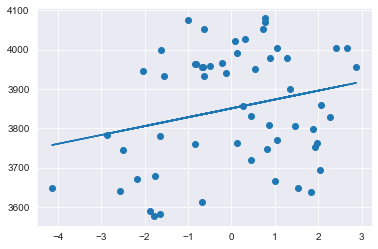

In [530]:
plt.plot(X_train,y_train_predict)
plt.scatter(X_train,Y_train)

### Régression linéaire II : Modèle de prédiction augmenté 


In [533]:
## Régression linéaire de "dernier_SP500" sur "indice" et "dernier_VIX"
xvars = ['dernier_VIX', 'indice']

df2 = df_reg_globale[["dernier_SP500"] + xvars]
indices_to_keep = ~df2.isin([np.nan, np.inf, -np.inf]).any(1)
df2 = df2[indices_to_keep].astype(np.float64)

X = sm.add_constant(df2.drop(["dernier_SP500"], axis = 1))
results = sm.OLS(df2[['dernier_SP500']], X).fit()
# Afficher le tableau de régression
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          dernier_SP500   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     244.8
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           1.59e-31
Time:                        17:38:07   Log-Likelihood:                -372.53
No. Observations:                  70   AIC:                             751.1
Df Residuals:                      67   BIC:                             757.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4691.8523     39.450    118.933      

Des résultats ci-dessus, le modèle prédit que en moyenne : 
- Une augmentation de 1 point de notre indice de " sentiment de marché" mène à une augmentation de 5 points de performance du SP500 ceteris paribus. Ce résultat est attendu, une augmentation de notre indice traduit un "sentiment de marché" à la hausse sorte d'euphorie boursière donc implique des performances du SP500 en hausse. Le coefficient associé à notre indice est significatif au seuil de 20.8%.     
- une augmentation de 1 point de l'indice VIX mène à une baisse de 32 point des performances du SP500 ceteris paribus. Ce résultat est attendu, une augmentation de l'indice VIX traduit un augmentation du niveau de "stress"/"peur" du marché ce qui mène à des performances du SP500 en baisse. Le coefficient associé à l'indice VIX est significatif au seuil de 1%. 

De plus, notre modèle explique 88% des variations des performances du SP500. 